#### Imports & Setup

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import csv
import cv2
import faiss
import pickle
import shelve

import numpy                 as np
import matplotlib.pyplot     as plt
import matplotlib.image      as mpimg


from keras.preprocessing     import image
from deepface.detectors      import FaceDetector
from api_classes             import Representation
from tqdm                    import tqdm
from uuid                    import uuid4
from deepface.commons        import functions, distance as dst

from deepface.DeepFace               import build_model as build_verifier
from deepface.detectors.FaceDetector import build_model as build_detector

In [3]:
# Setting up paths
API_DIR      = os.path.join(os.path.dirname(os.path.realpath("__file__")))
DST_ROOT_DIR = os.path.join(API_DIR     , 'data')
RAW_DIR      = os.path.join(DST_ROOT_DIR, 'raw')
#GALLERY_DIR  = os.path.join(DST_ROOT_DIR, 'gallery')
TARGETS_DIR  = os.path.join(DST_ROOT_DIR, 'targets')
RDB_DIR      = os.path.join(DST_ROOT_DIR, 'database')
SVD_MDL_DIR  = os.path.join(API_DIR     , 'saved_models')
SVD_VRF_DIR  = os.path.join(SVD_MDL_DIR , 'verifiers')

directory_list       = [API_DIR, DST_ROOT_DIR, RAW_DIR, TARGETS_DIR, RDB_DIR,
                        SVD_MDL_DIR, SVD_VRF_DIR]
directory_list_names = ['api root', 'dataset root', 'raw', 'targets',
                        'rep. database', 's. models', 's. verifiers']

# Print path names
print('  -> Path names:')
for name, fp in zip(directory_list_names, directory_list):
    print(f'Directory {name}'.ljust(25), f': {fp}', sep='')
print('')

  -> Path names:
Directory api root       : /home/rpessoa/projects/loki/api
Directory dataset root   : /home/rpessoa/projects/loki/api/data
Directory raw            : /home/rpessoa/projects/loki/api/data/raw
Directory targets        : /home/rpessoa/projects/loki/api/data/targets
Directory rep. database  : /home/rpessoa/projects/loki/api/data/database
Directory s. models      : /home/rpessoa/projects/loki/api/saved_models
Directory s. verifiers   : /home/rpessoa/projects/loki/api/saved_models/verifiers



In [4]:
# NOTE: These functions were copied directly to the notebook to avoid conflicts
# and issues when importing from separate Python files. FastAPI seems to work
# with relative imports while IPYNP seems to work with absolute imports, so to
# avoid this issue alltogether, just keep the functions local to this demo.

# ______________________________________________________________________________
#                                   FUNCTIONS
# ------------------------------------------------------------------------------

def detect_faces(img_path, detector_backend = 'opencv', align = True,
                 return_type = 'both', face_detector = None):
    """
    Detects faces in an image (and optionally aligns them).
    
    Inputs:
        1. img_path - image path, base64 image or numpy array image
        2. detector_backend - string corresponding to detector ([opencv],
            ssd, dlib, mtcnn, retinaface, mediapipe).
        3. align - flag indicating if face should be aligned ([align=True]).
        4. return_type - string indicating if faces, regions or both should
            be returned ('faces', 'regions', ['both']).
            
    Outputs:
        If return_type='regions':
            Dictionary containing list of face detections. The face detections
            (or regions of interest - rois) are lists with the format
            [top-left x, top-left y, width, height]. The dictionary key is
            'regions'.
            
        If return_type='faces':
            Dictionary containing list of detected faces. Each detection is an
            image with 'target_size' size (the number of color channels is
            unchanged). The dictionary key is 'faces'.
            
        If return_type='both':
            Dictionary containing both of the above outputs: face detections and
            detected faces. The dictionary keys are 'faces' and 'regions'. 
    
    Signature:
        output = detect_faces(img_path, detector_backend = 'opencv',
                              align = True, return_type = 'both')
    """
    # Raises an error if return type is not 'faces', 'regions' or 'both'.
    # Otherwise, initializes lists.
    if return_type == 'faces' or return_type == 'regions' or \
        return_type == 'both':
        faces = []
        rois  = []
    else:
        raise ValueError("Return type should be 'faces', 'regions' or 'both'.")
    
    # Loads image. Image might be path, base64 or numpy array. Convert it to
    # numpy whatever it is.
    img = functions.load_image(img_path)

    # The detector is stored in a global variable in FaceDetector object.
    # This call should be completed very fast because it will return found in
    # memory and it will not build face detector model in each call (consider
    # for loops)
    if face_detector == None:
        face_detector = FaceDetector.build_model(detector_backend)
    detections = FaceDetector.detect_faces(face_detector, detector_backend,
                                            img, align)

    # Prints a warning and returns an empty dictionary and error if no faces
    # were found, otherwise processes faces & regions
    if len(detections) == 0:
        print('Face could not be detected or the image contains no faces.')

    else:
        # Loops through each face & region pair
        for face, roi in detections:

            # Only process images (faces) if the return type is 'faces' or 
            # 'both'
            if return_type == 'faces' or return_type == 'both':
                # Appends processed face
                faces.append(face)
    
            # Only process regions (rois) if the return type is 'regions' or 
            # 'both'
            if return_type == 'regions' or return_type == 'both':
                rois.append(roi)

  # ------------------------
  
    if return_type == 'faces':
        return {'faces':faces}
    elif return_type == 'regions':
        return {'regions':rois}
    else:
        assert return_type == 'both', "Return type should be 'both' here."
        return {'faces':faces, 'regions':rois}

# ------------------------------------------------------------------------------

def get_image_paths(root_path, file_types=('.jpg', '.png')):
    """
    Gets the full paths of all 'file_types' files in the 'root_path' directory
    and its subdirectories. If the 'root_path' provided points to a file, this
    functions simply returns that path as a list with 1 element.

    Inputs:
        1. root_path  - full path of a directory
        2. file_types - tuple containing strings of file extensions
            ([file_types=('.jpg', '.png')])

    Output:
        1. list containing full path of all files in the directory and its
            subdirectories

    Example call:
        ROOT_PATH = path/to/some/folder/dude
        all_images = get_image_paths(ROOT_PATH, file_types=('.png'))
    """
    # If the root path points to file, simply return it as a list with 1 element
    if os.path.isfile(root_path):
        return [root_path]
    
    # Gets all images in this root directory
    all_images = []
    for root, _junk, files in os.walk(root_path):
        # Processes files in the root directory - can be transformed into a list
        # comprehension but code might lose clarity
        for file in files:
            if file.lower().endswith(file_types):
                exact_path = os.path.join(root, file)
                all_images.append(exact_path)
      
    return all_images

# ------------------------------------------------------------------------------

def create_dir(dir_path):
  """
  Creates a directory at the specified directory path 'dir_path' IF it does not
  exist. Returns a status of 0 is the directory was successfully created and 
  returns a status of 1 if a directory already exists.

  Inputs:
    1. dir_path - directory path of new directory.
    
  Outputs:
    1. status - 0 to indicate success (directory creation) or 1 to indicate
       failure (directory already exists)
    
  Signature:
    status = create_dir(dir_path)
  """
  # Create directory
  try:
    os.makedirs(dir_path)
    status = 0
  except FileExistsError:
    # Directory already exists
    status = 1

  return status

# ------------------------------------------------------------------------------

def batch_build_detectors(detector_names, show_prog_bar=True, verbose=True):
    """
    Builds batches of face detectors. The face detectors to be built are
    specified by the 'detector_names' list of names. If a face detectors cannot
    be built (or results in an error), it is simply skipped.
    
    Inputs:
        1. detector_names - list (of strings) of face detectors names
        2. show_prog_bar - boolean toggling a progress bar
            ([show_prog_bar=True])
        
    Outputs:
        1. dictionary of built face detector models
        
    Signature:
        detectors = batch_build_detectors(detector_names, show_prog_bar=True)
    """
    # Creates the progress bar
    n_detectors    = len(detector_names)
    disable_option = not show_prog_bar
    pbar           = tqdm(range(0, n_detectors), desc='Saving verifiers',
                            disable=disable_option)
    
    # 
    detectors      = {}
    for index, detector_name in zip(pbar, detector_names):
        try:
            cur_detector = build_detector(detector_name)
            detectors[detector_name] = cur_detector
            
        except Exception as excpt:
            pass
    
    return detectors

# ------------------------------------------------------------------------------

def batch_build_verifiers(verifier_names, show_prog_bar=True):
    """
    Builds batches of face verifiers. The face verifiers to be built are
    specified by the 'verifier_names' list of names. If a face verifier cannot
    be built (or results in an error), it is simply skipped.
    
    Inputs:
        1. verifier_names - list (of strings) of face verifier names
        2. show_prog_bar - boolean toggling a progress bar
                ([show_prog_bar=True])
        
    Outputs:
        1. dictionary of built face verifier models
        
    Signature:
        verifiers = batch_build_verifiers(verifier_names, show_prog_bar=True)
    """
    # Creates the progress bar
    n_verifiers    = len(verifier_names)
    disable_option = not show_prog_bar
    pbar           = tqdm(range(0, n_verifiers), desc='Building verifiers',
                            disable = disable_option)

    # 
    verifiers      = {}
    for index, verifier_name in zip(pbar, verifier_names):
        try:
            cur_verifier = build_verifier(verifier_name)
            verifiers[verifier_name] = cur_verifier

        except Exception as excpt:
            pass
        
    return verifiers

# ------------------------------------------------------------------------------

def saved_verifier_exists(verifier_name, save_dir=SVD_VRF_DIR):
    """
    Checks if a saved verifier exists with name 'verifier_name'. Does that by
    comparing the 'verifier_name' against the name of all files in 'save_dir'.
    
    Inputs:
        1. verifier_name - string with the name of the verifier.
        2. save_dir - string with the full path of the save directory
            ([save_dir=svd_vrf_dir]).
        
    Output:
        1. Boolean value indicating if saved verifier exists or not.
    
    Signature:
        verifier_exists = saved_verifier_exists(verifier_name,
                                                save_dir=svd_vrf_dir)
    """
    # Save directory provided is not a directory
    if not os.path.isdir(save_dir):
        return False
    
    # Otherwise, check if verifier name is in the names of files in the
    # 'save_dir' directory
    is_in = False
    for file_name in os.listdir(save_dir):
        is_in = is_in or verifier_name in file_name
    
    return is_in

# ------------------------------------------------------------------------------

def save_face_verifiers(verifiers, save_dir=SVD_VRF_DIR, show_prog_bar=True,
                        overwrite=False):
    """
    Saves all face verifier models specified in 'verifiers' using the 'shelve'
    (persistent storage) module. The models are saved in the 'save_dir'
    directory and each model is saved individually. Models that fail to save (or
    produces an error) are skipped. For each model that already exists, this
    function does not overwrite it unless the 'overwrite' flag is set to True.
    
    Inputs:
        1. verifiers - dictionary containing the build face verifier models.
        2. show_prog_bar - boolean that toggles the progress bar on or off.
        3. overwrite - boolean that indicates if the function should overwrite
                        any saved models.
                        
    Outputs:
        1. returns a status flag of True if any model fails to save (otherwise
            returns False)
    
    Signature:
        status = save_face_verifiers(verifiers, show_prog_bar=True,
                    overwrite=False)
    """
    # Checks if the save directory provided is a directory
    if not os.path.isdir(save_dir):
        return True
    
    # Creates the progress bar
    n_verifiers    = len(verifiers)
    disable_option = not show_prog_bar
    pbar           = tqdm(range(0, n_verifiers), desc='Saving verifiers',
                            disable = disable_option)
    
    # Loops through each verifier
    no_errors_flag = False # False means no errors
    for index, verifier_items in zip(pbar, verifiers.items()):
        # Gets the name of the verifier and the verifier object
        name     = verifier_items[0]
        verifier = verifier_items[1]
        
        if not saved_verifier_exists(name, save_dir=save_dir) or overwrite:
            try:
                # Creates the file's full path
                file_fp  = os.path.join(save_dir, name)
        
                # Opens a persistent dictionary, saves the model
                # as a dictionary then closes it
                with shelve.open(file_fp) as d:
                    d[name]  = verifier
            
            except Exception as excpt:
                no_errors_flag = True
            
    return no_errors_flag

# ------------------------------------------------------------------------------

def load_face_verifier(verifier_names, save_dir=SVD_VRF_DIR,
                        show_prog_bar=True, verbose=False):
    """
    Loads all face verifier models specified in 'verifier_names'. Alternatively,
    'all' can be passed as a 'verifier_name' to load all saved models. The
    models are loaded from the 'save_dir' directory.
      
    This function loads each model individually and skips any model that 
    fails to load (or produces an error).
    
    Inputs:
        1. verifier_name - string with the name of the face verifiers.
        2. save_dir      - string with the full path of the save directory
            ([save_dir='']).
        3. show_prog_bar - boolean that toggles the progress bar on or off.
                        
    Outputs:
        1. returns a status flag of True if any model fails to save (otherwise
            returns False)
            
    Signature:
        models = load_face_verifier(verifier_names, save_dir='',
                    show_prog_bar=True)
    """
    # Checks if the save directory provided is a directory
    if not os.path.isdir(save_dir):
        raise OSError(f'Save directory does not exist ({save_dir})!')
    
    # Ensures that the verifier_names is a list (even a single name is provided)
    if not isinstance(verifier_names, list):
        verifier_names = [verifier_names]
        
    # If 'all' was provided, use all model names
    if verifier_names[0].lower() == 'all':
        verifier_names = ['VGG-Face', 'OpenFace', 'Facenet', 'Facenet512',
                          'DeepFace', 'DeepID', 'ArcFace', 'Emotion', 'Age',
                          'Gender', 'Race']
    
    # Creates the progress bar
    n_verifiers    = len(verifier_names)
    disable_option = not show_prog_bar
    pbar           = tqdm(range(0, n_verifiers), desc='Loading verifiers',
                            disable = disable_option)
    
    models = {}
    for index, verifier_name in zip(pbar, verifier_names):       
        # Checks if the face verifier model exists
        if saved_verifier_exists(verifier_name, save_dir=save_dir):
            # Loads the model
            file_fp = os.path.join(save_dir, verifier_name)
            with shelve.open(file_fp) as model:
                if verbose:
                    print(f'[load_face_verifier] Loading model',
                          f'{verifier_name}: ', end='')
                try:
                    models[verifier_name] = model[verifier_name]
                    if verbose:
                        print('success!')
                except Exception as excpt:
                    if verbose:
                        print(f'failed! Reason: {excpt}\n',
                               '[load_face_verifier] Attempting to build',
                               ' & save model from scratch: ', sep='', end='')
                    try:
                        cur_model = build_verifier(verifier_name)
                        models[verifier_name] = cur_model
                        save_face_verifiers(cur_model, save_dir=save_dir,
                                            show_prog_bar=False, overwrite=True)
                        if verbose:
                            print('success!')
                    except Exception as excpt:
                        if verbose:
                            print(f'failed! Reason: {excpt}')
                                
        else:
            # Otherwise, tries to build model from scratch & save it
            if verbose:
                print(f'[load_face_verifier] Model {verifier_name} ',
                      'does not exist.', '\nAttempting to build & save model ',
                      'from scratch: ', sep='', end='')
            try:
                cur_model = build_verifier(verifier_name)
                models[verifier_name] = cur_model
                save_face_verifiers(cur_model, save_dir=save_dir,
                                    show_prog_bar=False, overwrite=False)
                if verbose:
                    print('success!')
            except Exception as excpt:
                if verbose:
                    print(f'failed! Reason: {excpt}')
    
    return models

# ------------------------------------------------------------------------------
        
def load_representation_db(file_path, verbose=False):
    """
    Loads a database (at 'file_path') containing representations of face images.
    The database is assumed to be a pickled Python object. The database is
    expected to be a list of Representation object (see help(Representation)
    for more information). If verbose is set to True, the loading processing is
    printed, with any errors being reported to the user.

    Inputs:
        1. file_path - string with file's full path
        2. verbose - flag indicating if the function should print information
            about the loading process and errors ([verbose=False])

    Output:
        1. database object (list of Representation objects)
    
    Signature:
        db = load_representation_db(file_path, verbose=False)
    """
    # Prints message
    if verbose:
        print('Opening database: ', end='')

    # Checks if path provided points to a valid database
    if os.path.isfile(file_path):
        # Try to open pickled database (list of objects)
        try:
            db = pickle.load(open(file_path, 'wb'))
            if verbose:
                print('success!')
        
        except (OSError, IOError) as e:
            if verbose:
                print(f'failed! Reason: {e}')
            db = []

    # If path does not point to a file, open an 'empty' database
    else:
        print(f'failed! Reason: database does not exist.')
        db = []

    return db
                
# ------------------------------------------------------------------------------

def process_face(img_path, target_size=(224, 224), normalization='base',
                    grayscale=False):
    """
    Applies some processing to an image of a face:
        1. Loads the image from an image path, base64 encoding or numpy array
        2. If the 'grayscale' flag is True, converts the image to grayscale
        3. Resizes the image based on the smallest factor (target_size /
            dimension) and zero pads the resized image to match the target size.
        4. If for some reason the image is still not the target size, resizes
            the modified image once again.
        5. Normalizes the image based on the normalization option:
            a. 'base': do nothing
            b. 'raw': restore input in scale of [0, 255]
            c. 'Facenet': 'raw' then subtract image mean and divide by image
                    standard deviation
            d. 'Facenet2018': 'raw' then divide by 127.5 and subtract 1
            e. 'VGGFace': 'raw' then mean subtraction based on VGGFace1 training
                    data
            f. 'VGGFace2': 'raw' then mean subtraction based on VGGFace2
                    training data
            g. 'ArcFace': based on a reference study, 'raw', then pixels are
                    normalized by subtracting 127.5 then dividing by 128.

    Inputs:
        1. img_path - image path, base64 image or numpy array
        2. target_size - tuple containing desired X and Y dimensions
            ([target_size=(224, 224)])
        3. normalization - defines a type of normalization
            ([normalization='base'])
        4. grayscale - flag indicating if image should be converted to grayscale
            ([grayscale=False])

    Output:
        1. processed image as a numpy array

    Signature:
        face_image = process_face(img_path, target_size=(224, 224),
                                  normalization='base', grayscale=False)
    """
    # Loads the face image. Image might be path, base64 or numpy array. Convert
    # it to numpy whatever it is.
    face = functions.load_image(img_path)
    
    # Ensures that both dimensions are >0, otherwise raises error
    if face.shape[0] == 0 or face.shape[1] == 0:
        raise ValueError(f'Detected face shape is {face.shape}.')

    # Converts to grayscale if face is 
    if grayscale:
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                
    # Resizes face
    if face.shape[0] > 0 and face.shape[1] > 0:
        factor_0 = target_size[0] / face.shape[0]
        factor_1 = target_size[1] / face.shape[1]
        factor   = min(factor_0, factor_1)

    dsize  = (int(face.shape[1] * factor), int(face.shape[0] * factor))
    face   = cv2.resize(face, dsize)

    # Then pad the other side to the target size by adding black pixels
    diff_0 = target_size[0] - face.shape[0]
    diff_1 = target_size[1] - face.shape[1]
                
    if not grayscale:
        # Put the base image in the middle of the padded image
        face = np.pad(face, ((diff_0 // 2, diff_0 - diff_0 // 2),
                             (diff_1 // 2, diff_1 - diff_1 // 2), (0, 0)),
                             'constant')
    else:
        face = np.pad(face, ((diff_0 // 2, diff_0 - diff_0 // 2),
                             (diff_1 // 2, diff_1 - diff_1 // 2)),
                             'constant')

    # Double check if target image is not still the same size with target.
    if face.shape[0:2] != target_size:
        face = cv2.resize(face, target_size)

    # Normalizing the image pixels
    if normalization == 'base':
        face  = image.img_to_array(face) #what this line doing? must?
        face  = np.expand_dims(face, axis = 0)
        face /= 255 # normalize input in [0, 1]
    else:
        face = functions.normalize_input(face, normalization=normalization)
    
    return face

# ------------------------------------------------------------------------------

def find_image_in_db(img_path, db, shortcut=None):
    """
    Finds the corresponding Representation in the database 'db'. Uses the
    image's name obtained from its full path ('img_path') to match the
    Representation to the image. An optional dictionary ('shortcut') can be
    provided where each letter corresponds to an index to speed up the search.
    Consider a sorted database where the first image with a name starting with
    a 'g' is at position 156. Then a shortcut dictionary with the key/value pair
    'g':155 will ensure this function starts at the position 156 and wont waste
    time previous database entries.

    Inputs:
        1. img_path - image path, base64 image or numpy array
        2. db - database object (list of Representation objects)
        3. shortcut - optional dictionary with letter/index key/value pairs
            ([shortcut=None])

    Output:
        1. tuple containing the matching Representation object and the index
            corresponding to that object in the database (i.e. output
            representation == database[output index]). If no match is found,
            both representation and index are returned as empty lists. If
            multiple entries are found, multiple Representations and indexs are
            returned as lists.
    """
    rep_objs = [] # empty representation object
    rep_idxs = [] # no matching index

    # Database is empty
    if len(db) == 0:
        pass # do nothing

    # 'shortcut' dictionary is provided
    elif not shortcut == None:
        # Get image name
        img_name = img_path.split('/')[-1].lower()
        idx      = shortcut[img_name[0]]

        # 
        for i, rep in enumerate(db[idx::]):
            if img_name.lower() == rep.image_name:
                rep_objs.append(rep)
                rep_idxs.append(i + idx)

    # 'shortcut' dictionary is not provided
    else:
        # Get image name
        img_name = img_path.split('/')[-1].lower()

        # 
        for i, rep in enumerate(db):
            if img_name.lower() == rep.image_name:
                rep_objs.append(rep)
                rep_idxs.append(i)

    return (rep_objs, rep_idxs)

# ------------------------------------------------------------------------------

def create_new_representation(img_path, region, embeddings, tag='', uid='',
                                ignore_taglist=['--', '---']):

    # If Unique IDentifier (UID) is not provided, generate one
    if len(uid) == 0 or uid == '':
        uid = uuid4()

    # If tag is in the ignore taglist, then it is considered as a "ignore" tag
    if tag in ignore_taglist:
        tag = ''

    # Returns the new representation
    return Representation(uid, image_name=img_path.split('/')[-1], 
                          image_fp=img_path, name_tag=tag, region=region,
                          embeddings=embeddings)

# ------------------------------------------------------------------------------

def update_representation(rep, embeddings):
    """
    TODO: Add description
    """

    # Loops through each model name and embedding pair, adding or updating the 
    # corresponding value in the embeddings dictionary of the representation 
    # provided
    for model_name, embedding in embeddings.items():
        rep.embeddings[model_name] = embedding

    return rep

# ------------------------------------------------------------------------------

def get_embeddings_as_array(db, verifier_name):
    """
    Gets all of the embeddings for a given 'verifier_name' from the database
    'db' and returns it as a N x M numpy array where N is the number of
    embeddings and M is the number of elements of each embeddings.

    Inputs:
        1. db - database object (list of Representation objects)
        2. verifier_name - name of verifier

    Output:
        1. N x M numpy array where each row corresponds to a face image's
            embedding

    Signature:
        embeddings = get_embeddings_as_array(db, verifier_name)
    """
    embeddings = [] # initializes empty list
    for rep in db:
        embeddings.append(rep.embeddings[verifier_name])

    return np.array(embeddings)

# ------------------------------------------------------------------------------

def create_faiss_index(embeddings, metric='cosine'):
    """
    Create faiss indexes from 'embeddings'. Embeddings are expected to be a
    N x M numpy array with N embeddings each with M elements.

    Inputs:
        1. embeddings - N x M numpy array
        2. metric - string specifying the distance/similarity metric ([cosine],
            euclidean, euclidean_l2)

    Output:
        1. index object with embeddings added

    Signature:
        index = create_faiss_index(embeddings, metric='cosine')
    """
    # Create the appropriate index based on the distance metric provided. If the
    # distance metric provided is not valid (not cosine, euclidean or
    # euclidean_l2), an error is raised.
    if metric == 'cosine':
        index = faiss.IndexFlatIP(embeddings.shape[1])
    elif metric in ['euclidean', 'euclidean_l2']:
        index = faiss.IndexFlatL2(embeddings.shape[1])
    else:
        raise ValueError(f'{metric} is an invalid metric!',
                          'Expected cosine, euclidean or euclidean_l2.',
                          sep='\n')
    
    # Applies L2 normalization in the cases of cosine or euclidean_l2 metrics
    if metric in ['cosine', 'euclidean_l2']:
        embeddings = dst.l2_normalize(embeddings)

    # Adds the embeddings to the index object
    index.add(embeddings)

    return index

# ------------------------------------------------------------------------------

def load_faiss_indexes(idx_path, embeddings=None, metric='cosine',
                        verbose=False):
    """
    If 'embeddings' == None, attempts to load a faiss index object saved at
    'idx_path'. If 'embeddings' is not None and the path provided does not point
    to a valid file, creates a new index object using 'embeddings'. Finally, if
    the file path provided is valid and 'embeddings' is not None, attempts to
    load the index object and add the embeddings provided. Once again, on
    failure, a new index object is created.

    Input:
        1. idx_path - full path to file containing index object
        2. embeddings - N x M numpy array or None ([embeddings=None])
        3. metric - string specifying the distance/similarity metric ([cosine],
            euclidean, euclidean_l2)
        4. verbose - boolean flag controlling if the function prints creation
            and error messages ([verbose=True])

    Output:
        1. faiss index object
    
    Signature:
        index = load_faiss_indexes(idx_path, embeddings=None, metric='cosine',
                                    verbose=False)
    """
    # If embeddings is None, attempts to load the index object. If the loading
    # process fails, None is returned.
    if embeddings is None:
        # Attempts to load index path
        if verbose:
            print('Loading index object: ', sep='', end='')

        try:
            # Loading index object
            index = faiss.read_index(idx_path)
            if verbose:
                print(f'success!')

        except Exception as excpt:
            # Loading failed. Print exception if verbose == True and create new
            # index object
            if verbose:
                print(f'failed! Reason: {excpt}')
            index = None

    # Index path is not file (or does not exist) so attempt to create a new
    # index object and add the embeddings provided (remember, they are not None)
    elif not os.path.isfile(idx_path):
        if verbose:
            print('Creating index object: ', sep='', end='')

        try:
            index = create_faiss_index(embeddings, metric=metric)
            if verbose:
                print(f'success!')

        except Exception as excpt:
            if verbose:
                print(f'failed! Reason: {excpt}')
            index = None

    # Otherwise, attempts to load the index object at the file path provided
    else:
        # Attempts to load index path
        if verbose:
            print('Loading index object: ', sep='', end='')

        try:
            # Loading index object
            index = faiss.read_index(idx_path)
            index.add(embeddings)
            if verbose:
                print(f'success!')

        except Exception as excpt:
            # Loading failed. Print exception if verbose == True and create new
            # index object
            if verbose:
                print(f'failed! Reason: {excpt}')
                print('Creating new indexes.')
            
            index = create_faiss_index(embeddings, metric=metric)

    return index

# ------------------------------------------------------------------------------

def verify_with_faiss(target_embd, index, db, top_x=3, model_name='VGG-Face',
                      metric='cosine', threshold=-1):
    """
    Uses the Faiss library to speed up the verification process. The 'index'
    object is a faiss-specific object with the embeddings of the whole database
    'db'. Using faiss fast search, the 'top_x' nearest neighbour embeddings are
    obtained and a subset of the original database is created.

    The similarity (and matches) are then calculated using the subset database,
    which is only 'top_x' large. Note that the speed gains are more noticeable
    for larger databases and small values of 'top_x'. Also note that if there
    are more than 'top_x' matches, then only 'top_x' will be returned.

    Inputs:
        1. target_embd - 1-D numpy array containing the embedding.
        2. index - faiss-specific index object. Use 'load_faiss_indexes'
                function to create it.
        3. db - database (list of Representation objects)
        4. top_x - natural number indicating the number of nearest neighbours to
                filter the database ([top_x=3])
        5. model_name - string specifying the model name (['VGG-Face']).
        6. metric - string specifying the distance metric to be used
                (['cosine'], 'euclidean', 'l2_euclidean').
        7. threshold - if a negative float is provided, then the threshold is
                calculated automatically based on the model name provided.
                Otherwise, the threshold provided is used ([threshold=-1]).
    
    Output:
        1. dictionary containing the indexes of matches (key: idxs), the
            threshold value used (key: threshold) and the distances calculated
            using the specified metric (key: distances). Note that if no match
            is found, then the 'indexes' will have a length of zero (i.e. will
            be empty).

    Signature:
        similarity_obj = verify_with_faiss(target_embd, index, db, top_x=3,
                                    model_name='VGG-Face', metric='cosine',
                                    threshold=-1)
    """
    # Obtains the 'top_x' nearest neighbours
    distances, neighbors = index.search(target_embd, top_x)

    # Obtains the embeddings for the 'filtered' (top_x) representations
    filtered_reps  = [db[i] for i in np.array(neighbors[0], dtype=int)]
    embds          = get_embeddings_as_array(filtered_reps, model_name)

    # Calculates the matches to the target embedding (from the top_x filtered
    # set of representations)
    similarity_obj = calc_similarity(target_embd, embds, metric=metric,
                                     model_name=model_name, threshold=threshold)

    return similarity_obj

# ------------------------------------------------------------------------------

def calc_cosine_similarity(A, B):
    """
    Calculates the cosine similarity metric between matrices A and B. If A is a
    vector, it is converted into a matrix so that the cosine metric can be
    calculated normally.

    Inputs:
        1. A - N x M matrix with N embeddings with M elements
        2. A - I x M matrix with I embeddings with M elements

    Outputs:
        1. matrix of cosine similarity metric between A and B

    Signature:
        csm = calc_cosine_similarity(A, B)
    """
    if A.ndim == 1:
        A = A[np.newaxis, :]

    num = np.dot(A, B.T)
    p1  = np.sqrt(np.sum(A**2, axis=1))[:, np.newaxis]
    p2  = np.sqrt(np.sum(B**2, axis=1))[np.newaxis, :]
    return 1 - (num / (p1 * p2))

# ------------------------------------------------------------------------------

def calc_euclidean_similarity(A, B, l2_normalize=False):
    """
    Calculates the Euclidean similarity metric between matrices A and B. If A is
    a vector, it is converted into a matrix by repeating (and stacking) it
    horizontally until it has the correct dimensions. If 'l2_normalize' is set
    to True, then the function applies L2 normalization to the inputs before
    calculating the Euclidean similarity (distance).

    Inputs:
        1. A - N x M matrix with N embeddings with M elements
        2. A - I x M matrix with I embeddings with M elements
        3. l2_normalize - boolean to indicate if the inputs should be L2
            normalized before calculating the similarity ([l2_normalize=True])

    Outputs:
        1. matrix of Euclidean similarity metric between A and B

    Signature:
        edm = calc_euclidean_similarity(A, B, l2_normalize=False)
    """
    # Applies l2 normalization to the inputs if necessary
    if l2_normalize:
        if A.ndim == 1:
            A = A / np.sqrt(np.sum(np.multiply(A, A)))
        else:
            A = np.transpose(A.T / np.linalg.norm(A, axis=1))

        if B.ndim == 1:
            B = B / np.sqrt(np.sum(np.multiply(B, B)))
        else:
            B = np.transpose(B.T / np.linalg.norm(B, axis=1))

    # 'Repeats vertically' vector A until it is a matrix with appropriate
    # dimensions 
    if A.ndim == 1:
        A = np.tile(A, (B.shape[0], 1))

    # Calcultes and returns the Euclidean distance
    return np.sqrt(np.sum((A - B) * (A - B), axis=1))

# ------------------------------------------------------------------------------

def calc_similarity(tgt_embd, embds, metric='cosine', model_name='VGG-Face',
                    threshold=-1):
    """
    Calculates the similarity (distance) between both embeddings ('tgt_embd'
    and 'embds') using the 'metric' distance metric. If the 'threshold' < 0 then
    it is automatically determined based on the 'model_name' provided. If a 
    custom threshold is specified, then the 'model_name' input is unused.

    Note that 'embds' can be a N x M matrix (N embeddings each with M elements)
    and 'tgt_embd' can only be a 1 x M embedding.

    Inputs:
        1. tgt_embd - 1-D numpy array containing the embedding.
        2. embds - 1-D or 2-D numpy array containing the embedding(s).
        3. metric - string specifying the distance metric to be used
            (['cosine'], 'euclidean', 'l2_euclidean').
        4. model_name - string specifying the model name (['VGG-Face']).
        5. threshold - if a negative float is provided, then the threshold is
            calculated automatically based on the model name provided.
            Otherwise, the threshold provided is used ([threshold=-1]).

    Output:
        1. dictionary containing the indexes of matches (key: idxs), the
            threshold value used (key: threshold) and the distances calculated
            using the specified metric (key: distances). Note that if no match
            is found, then the 'indexes' will have a length of zero (i.e. will
            be empty).
    
    Signature:
        similarity_obj = calc_similarity(tgt_embd, embds, metric='cosine',
                                         model_name='VGG-Face', threshold=-1)
    """
    # Calculates the distance based on the metric provided, otherwise raises a
    # value error
    if metric == 'cosine':
        distances = calc_cosine_similarity(tgt_embd, embds)
    elif metric == 'euclidean':
        distances = calc_euclidean_similarity(tgt_embd, embds)
    elif metric == 'euclidean_l2':
        distances = calc_euclidean_similarity(tgt_embd, embds,
                                              l2_normalize=True)
    else:
        raise ValueError(f'Invalid metric passed: {metric}')

    # If threshold is negative, determine threshold automatically based on the
    # model name and distance metric
    if threshold < 0:
        threshold = dst.findThreshold(model_name, metric)
    
    # Makes a decision
    decision = (distances <= threshold).squeeze()
    return {'idxs': np.where(decision)[0],
            'threshold': threshold,
            'distances': distances}

# ------------------------------------------------------------------------------

def calc_embedding(img_path, verifier_models, detector_name='opencv',
                    align=True, verifier_names='VGG-Face',
                    normalization='base'):
    """
    TODO: ADD DESCRIPTION
    """
    # Converts verifier names into a list if it is a single entry
    if not isinstance(verifier_names, list):
        verifier_names = [verifier_names]

    # Tries to detect faces & align:
    try:
        output = detect_faces(img_path, detector_backend=detector_name,
                                align=align, return_type='both',
                                face_detector=None)
    except:
        print('[calc_embedding] Error: face detection failed!')
        return ([], {})

    # TODO: MAKE THE FUNCTION ACCEPT MULTIPLE FACES IN ONE IMAGE
    # Since we assume there is only 1 face (and region):
    face   = output['faces'][0]
    region = output['regions'][0]

    # For each verifier model provided
    embeddings={}
    for verifier_name in verifier_names:
        try:
            # Gets the current verifier model
            model = verifier_models[verifier_name]

            # Determine target size
            input_x, input_y = functions.find_input_shape(model)

            # Process face
            processed_face = process_face(face, target_size=(input_x, input_y),
                                    normalization=normalization, grayscale=False)

            # Calculate embeddings
            embeddings[verifier_name] = model.predict(processed_face)[0]
        except:
            pass

    return (region, embeddings)

# ------------------------------------------------------------------------------

def create_reps_from_dir(img_dir, verifier_models, detector_name='opencv',
                    align=True, verifier_names='VGG-Face', show_prog_bar=True,
                    normalization='base', tags=[], uids=[], verbose=False):
    """
    Creates a representations from images in a directory 'img_dir'. The
    representations are returned in a list, and the list of representations. If
    tags and/or unique identifiers (uids) are provided, make sure that they 
    correspond to the sorted (ascending) image names contained in 'img_dir'.

    Inputs:
        1. img_dir - string with the full path to the directory containing the
            images.

        2. verifier_models - dictionary containing model name (key) and model
            object (value).

        3. detector_name - string with the face detector name ([opencv], ssd,
            dlib, mtcnn, retinaface).
        
        4. align - boolean flag to indicate if face images should be aligned.
            Improves face recognition performance at the cost of some speed
            ([True], False).

        5. verifier_names - string with the face verifier name ([VGG-Face],
            OpenFace, Facenet, Facenet512, DeepFace, DeepID, ArcFace).

        6. show_prog_bar - boolean that toggle the progress bar on or off
            ([True], False).

        7. normalization - normalizes the face image and may increase face
            recognition performance depending on the normalization type and the
            face verifier model ([base], raw, Facenet, Facenet2018, VGGFace,
            VGGFace2, ArcFace).

        8. tags - list of strings where each string corresponds to a tag for the
            i-th image, i.e. tags[0] is the tag for the first image in the
            sorted list of image name obtain from 'img_dir' directory. If an
            empty list is provided, this is skipped during the representation
            creation process ([tags=[]]).

        9. uids - list of strings where each string corresponds to a unique
            identifier (UID) for the i-th image, i.e. uids[0] is the UID for the
            first image in the sorted list of image name obtain from 'img_dir'
            directory. If an empty list is provided, a UID is created for each
            image during the representation creation process ([uids=[]]).
            
        10. verbose - boolean to toggle function warnings and other messages
            ([True], False).

        Note: the 'tags' and 'uids' lists (inputs 8 and 9) must have the same
        number of elements (length) and must match the number of images in
        'img_dir'. If not, these inputs will be treated as empty lists (i.e.
        ignored).

    Outputs:
        1. list of Representation objects. For more information about the
            Representation class attributes and methods, use
            help(Representation)

    Signature:
        rep_db = create_reps_from_dir(img_dir, verifier_models, 
                        detector_name='opencv', align=True,
                        verifier_names='VGG-Face', show_prog_bar=True,
                        normalization='base', tags=[], uids=[], verbose=False)
    """
    # Initializes skip flags and database (list of Representation objects)
    skip_tag = False
    skip_uid = False
    rep_db   = []
    
    # Assuming img_dir is a directory containing images
    img_paths = get_image_paths(img_dir)
    img_paths.sort()

    # No images found, return empty database
    if len(img_paths) == 0:
        return []

    # If tags list does not have the same number of elements as the images (i.e.
    # 1 tag per image), ignore it
    if len(tags) != len(img_paths):
        if verbose:
            print('[create_reps_from_dir] Number of tags and image paths',
                  'must match. Ignoring tags list.')
        skip_tag = True

    # If uids list does not have the same number of elements as the images (i.e.
    # 1 UID per image), ignore it
    if len(uids) != len(img_paths):
        if verbose:
            print('[create_reps_from_dir] Number of UIDs and image paths',
                  'must match. Ignoring uids list.')
        skip_uid = True

    # Creates the progress bar
    n_imgs  = len(img_paths)
    disable = not show_prog_bar
    pbar    = tqdm(range(0, n_imgs), desc='Creating representations',
                    disable=disable)

    # Loops through each image in the 'img_dir' directory
    for pb_idx, i, img_path in zip(pbar, range(0, n_imgs), img_paths):
        # Calculate the face image embedding
        region, embeddings = calc_embedding(img_path, verifier_models,
                                            align=align,
                                            detector_name=detector_name, 
                                            verifier_names=verifier_names,
                                            normalization=normalization)

        # Determines if tag was provided and should be used when creating this
        # representation
        if skip_tag:
            tag = ''
        else:
            tag = tags[i]

        # Determines if UID was provided and should be used when creating this
        # representation
        if skip_uid:
            uid = ''
        else:
            uid = uids[i]

        # Create a new representation and adds it to the database
        rep_db.append(create_new_representation(img_path, region, embeddings,
                                                tag=tag, uid=uid))

    # Return representation database
    return rep_db

# ------------------------------------------------------------------------------

In [7]:
# Builds detectors
# all_detectors = batch_build_detectors(DETECTOR_NAMES, verbose=False)
# print('=' * 80, all_detectors, sep='\n')

# Builds verifiers
# all_verifiers = batch_build_verifiers(VERIFIER_NAMES, show_prog_bar=True)
# print('=' * 80, all_verifiers, sep='\n')

# Save verifiers
# save_face_verifiers(all_verifiers, API_DIR)

# Loading just the ArcFace model as this model will be used throughout this demo
models = load_face_verifier(['ArcFace'], save_dir=SVD_VRF_DIR,
                            show_prog_bar=False, verbose=True)
print('\n', models)

[load_face_verifier] Loading model ArcFace: success!

 {'ArcFace': <keras.engine.functional.Functional object at 0x7f544dd767c0>}


### FR Pipeline as 1 function - not useful for now

In [10]:
# Database functions & classes

def fr_pipeline(img_path, rep_db, models, chosen_model='VGG-Face',
                force_update=False, chosen_backend='opencv', align=True,
                normalization='base', tags=''):

    # Obtains the image paths
    if os.path.isfile(img_path):
        img_paths = [img_path]
    elif os.path.isdir(img_path):
        img_paths = get_image_paths(img_path)
    else:
        raise ValueError("Expected 'img_paths' to point to a file or directory!")


    # Handle different 'tags' type
    if os.path.isfile(tags):
        # Handles different file types:
        # CSV files
        if tags[-3::].lower() == 'csv':
            with open(tags, newline='') as f:
                reader = csv.reader(f)
                tags   = list(reader)

        else:
            raise ValueError("{} file type not implemented for tags!".format(\
                             tags.split('.')[-1]))

    # Handles single string
    elif isinstance(tags, str):
        temp = []
        for i in range(0, len(img_paths)):
            temp.append(tags[0])
        tags = temp

    else:
        raise ValueError(f"{type(tags)} not implemented for tags!")


    # Determine target size
    input_shape_x, input_shape_y = \
                            functions.find_input_shape(models[chosen_model])

    # Loops through each image
    for pth, tag in zip(img_paths, tags):
        # Finds if the image has already a saved representation in the database
        rep, idx = find_image_in_db(pth, rep_db, shortcut=None)
        print(f'idx: {idx} | file path: {pth}')

        # No representation found
        if len(rep) == 0 or len(idx) == 0:
            # Detect faces & align:
            output = detect_faces(img_path, detector_backend=chosen_backend,
                                  align=align, return_type='both',
                                  face_detector=None)

            # TODO: MAKE THE FUNCTION ACCEPT MULTIPLE FACES IN AN IMAGE
            # Since we assume there is only 1 face (and region):
            face   = output['faces'][0]
            region = output['regions'][0]

            # Process face
            face = process_face(face,
                                target_size=(input_shape_x, input_shape_y),
                                normalization=normalization, grayscale=False)

            # Create representation
            embeddings={}
            embeddings[chosen_model] = models[chosen_model].predict(face)[0]

            if tag == '-':
                tag = ''  # handle tag "no tag" tag
            
            cur_rep = Representation(uuid4(),
                        image_name=img_path.split('/')[-1],
                        image_fp=img_path,
                        name_tag=tag, # user would add a name here through a GUI
                        region=region,
                        embeddings=embeddings)

            # Add representation to database
            rep_db.append(cur_rep)

        # Use existing representation
        elif chosen_model in list(rep[0].embeddings.keys()) and \
             not force_update:
            pass # do some other stuff

        # Update representation
        elif force_update or \
             not (chosen_model in list(rep[0].embeddings.keys())):
            pass # other other stuff

# ------------------------------------------------------------------------------


In [ ]:
chosen_model      = 'ArcFace'
chosen_backend    = 'retinaface'
align             = True
normalization     = 'base'
similarity_metric = 'cosine'
image_paths       = get_image_paths(RAW_DIR)
targets_paths     = get_image_paths(TARGETS_DIR)
image_tags        = ['Jennifer Aniston', 'Angelina Jolie', 'Angelina Jolie',
                     'Scarlett Johansson', 'Mark Zuckerberg', 'Elon Musk',
                     'Jeff Bezos', 'Sundar Pichai', 'Katy Perry']
db_path           =  RDB_DIR # no database exists

fr_pipeline(RAW_DIR, rep_db, chosen_model=chosen_model,
            chosen_backend=chosen_backend, align=align,
            normalization=normalization)

idx: [7] | file path: /home/rpessoa/projects/loki/api/data/raw/img7.jpg
idx: [6] | file path: /home/rpessoa/projects/loki/api/data/raw/img5.jpg
idx: [5] | file path: /home/rpessoa/projects/loki/api/data/raw/img3.jpg
idx: [1] | file path: /home/rpessoa/projects/loki/api/data/raw/img18.jpg
idx: [4] | file path: /home/rpessoa/projects/loki/api/data/raw/img26.jpg
idx: [8] | file path: /home/rpessoa/projects/loki/api/data/raw/img8.jpg
idx: [3] | file path: /home/rpessoa/projects/loki/api/data/raw/img24.jpg
idx: [0] | file path: /home/rpessoa/projects/loki/api/data/raw/img15.jpg
idx: [2] | file path: /home/rpessoa/projects/loki/api/data/raw/img21.jpg


In [40]:
chosen_model in list(rep_db[0].embeddings.keys())

True

### Step-by-step

Opening database: failed! Reason: database does not exist.
UID: 8513e266-fd13-4a15-b50d-61a0e0a27a25 | Name: img03.jpg | Path: /home/rpessoa/projects/loki/api/data/raw/img03.jpg


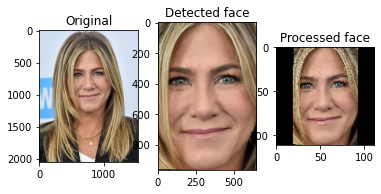

In [8]:
# User selects 1 (or X) models. Let's start with 1 model for now:
chosen_model   = 'ArcFace'
chosen_backend = 'retinaface'
align          = True
normalization  = 'base'
img_path       = os.path.join(RAW_DIR, 'img03.jpg') # this is an example of an image path
#              = os.path.join(RAW_DIR) # this is an example of a directory path
db_path        =  RDB_DIR

# 0a. Loads all the models: this has been done before
# 0b. Loads representation database
rep_db = load_representation_db(db_path, verbose=True)

# 1. Check if a representation exists for the current image in the database
rep, idx = find_image_in_db(img_path, rep_db, shortcut=None)

# 2. Detect faces & align:
output = detect_faces(img_path, detector_backend=chosen_backend,
                      align=align, return_type='both', face_detector=None)

# Since we assume there is only 1 face (and region):
face   = output['faces'][0]
region = output['regions'][0]

fig, axs = plt.subplots(1, 3);
axs = axs.flatten();
axs[0].imshow(mpimg.imread(img_path))
axs[0].set_title('Original')
axs[1].imshow(face[:, :, ::-1])
axs[1].set_title('Detected face')
plt.show

# 3a. Determine target size
input_shape_x, input_shape_y = functions.find_input_shape(models[chosen_model])

# 3b. Process face
face = process_face(face, target_size=(input_shape_x, input_shape_y),
                    normalization=normalization, grayscale=False)
axs[2].imshow(np.squeeze(face)[:, :, ::-1])
axs[2].set_title('Processed face');

# 4. Create representation
embeddings={}
embeddings[chosen_model] = models[chosen_model].predict(face)[0]

cur_rep = Representation(uuid4(),
                         image_name=img_path.split('/')[-1],
                         image_fp=img_path,
                         name_tag='', # user would add a name here through a GUI
                         region=region,
                         embeddings=embeddings)

# 5. Add representation to database
rep_db.append(cur_rep)

# - Print database summary
for i in range(len(rep_db)):
    print(f'UID: {rep_db[i].unique_id}',
          f'Name: {rep_db[i].image_name}'.ljust(15),
          f'Path: {rep_db[i].image_fp}', sep=' | ')

### Test Example 1

First, building a database using the images in the *'/data/raw'* directory.
Then, apply the same pipeline to verify the images in the *'/data/targets'* directory.

This is a step-by-step example.

In [32]:
# User selects 1 (or X) models. Let's start with 1 model for now:
chosen_model      = 'ArcFace'
chosen_backend    = 'retinaface'
align             = True
normalization     = 'base'
similarity_metric = 'cosine'
image_paths       = get_image_paths(RAW_DIR)
targets_paths     = get_image_paths(TARGETS_DIR)
image_tags        = ['Jennifer Aniston', 'Angelina Jolie', 'Angelina Jolie',
                     'Scarlett Johansson', 'Mark Zuckerberg', 'Elon Musk',
                     'Jeff Bezos', 'Sundar Pichai', 'Katy Perry']
db_path           =  RDB_DIR # no database exists

image_paths.sort()
targets_paths.sort()

# 0a. Loads all the models: this has been done before
# 0b. Loads representation database
rep_db   = load_representation_db(db_path, verbose=True) # this will be empty
n_images = len(image_paths)
print('')

# Let's do the whole pipeline for each image
for i, img_path, tag in zip(range(n_images), image_paths, image_tags):
    # Current iteration and image
    temp = img_path.split('/')[-1]
    print(f'Image {i}:', f'{tag}'.ljust(20), f'({temp})')

    # 1. Check if a representation exists for the current image in the database
    rep, idx = find_image_in_db(img_path, rep_db, shortcut=None) # for now, no representation exists

    # 2. Detect faces & align:
    output = detect_faces(img_path, detector_backend=chosen_backend,
                          align=align, return_type='both', face_detector=None)

    # Since we assume there is only 1 face (and region):
    face   = output['faces'][0]
    region = output['regions'][0]

    # 3a. Determine target size
    input_shape_x, input_shape_y = \
        functions.find_input_shape(models[chosen_model])

    # 3b. Process face
    face = process_face(face, target_size=(input_shape_x, input_shape_y),
                    normalization=normalization, grayscale=False)

    # 4. Create representation
    embeddings={}
    embeddings[chosen_model] = models[chosen_model].predict(face)[0]

    cur_rep = Representation(uuid4(),
                        image_name=img_path.split('/')[-1],
                        image_fp=img_path,
                        name_tag=tag, # user would add a name here through a GUI
                        region=region,
                        embeddings=embeddings)

    # 5. Add representation to database
    rep_db.append(cur_rep)

print('\n', '*'*100, '\n')

# Sort database
rep_db.sort(key=lambda x: x.image_name)
    
# - Print database summary
for i in range(len(rep_db)):
    print(f'UID: {rep_db[i].unique_id}',
          f'Tag: {rep_db[i].name_tag}'.ljust(25),
          f'Path: {rep_db[i].image_fp}', sep=' | ')

Opening database: failed! Reason: database does not exist.

Image 0: Jennifer Aniston     (img7.jpg)
Image 1: Angelina Jolie       (img5.jpg)
Image 2: Angelina Jolie       (img3.jpg)
Image 3: Scarlett Johansson   (img18.jpg)
Image 4: Mark Zuckerberg      (img26.jpg)
Image 5: Elon Musk            (img8.jpg)
Image 6: Jeff Bezos           (img24.jpg)
Image 7: Sundar Pichai        (img15.jpg)
Image 8: Katy Perry           (img21.jpg)

 **************************************************************************************************** 

UID: 3aa7847d-62db-4921-8546-ef73c18c5cb1 | Tag: Sundar Pichai        | Path: /home/rpessoa/projects/loki/api/data/raw/img15.jpg
UID: 5f41b411-f555-429f-aa65-95f681d4b1aa | Tag: Scarlett Johansson   | Path: /home/rpessoa/projects/loki/api/data/raw/img18.jpg
UID: a10dcd98-0a8a-41c6-93f7-46f36b564b12 | Tag: Katy Perry           | Path: /home/rpessoa/projects/loki/api/data/raw/img21.jpg
UID: e277c0ba-09ce-40da-b43a-255296d36a1c | Tag: Jeff Bezos           | Pa

In [8]:
fr_results   = []

# Let's do the whole pipeline for each image
for i, img_path in zip(range(len(targets_paths)), targets_paths):
    # Current iteration and image
    temp = img_path.split('/')[-1]
    print(f'Target {i}: {temp}'.ljust(22), end='')

    # 1. Check if a representation exists for the current image in the database
    rep, idx = find_image_in_db(img_path, rep_db, shortcut=None) # for now, no representation exists

    # 2. Detect faces & align:
    output = detect_faces(img_path, detector_backend=chosen_backend,
                          align=align, return_type='both', face_detector=None)

    # Since we assume there is only 1 face (and region):
    face   = output['faces'][0]
    region = output['regions'][0]

    # 3a. Determine target size
    input_shape_x, input_shape_y = \
        functions.find_input_shape(models[chosen_model])

    # 3b. Process face
    face = process_face(face, target_size=(input_shape_x, input_shape_y),
                    normalization=normalization, grayscale=False)

    # 4. Create representation
    embeddings={}
    embeddings[chosen_model] = models[chosen_model].predict(face)[0]

    cur_rep = Representation(uuid4(),
                        image_name=img_path.split('/')[-1],
                        image_fp=img_path,
                        name_tag='', # user would add a name here through a GUI
                        region=region,
                        embeddings=embeddings)

    # 5. Calculates similarity between the current image and the entire database
    matches = []
    cur_emb = cur_rep.embeddings[chosen_model]
    for rep in rep_db:
        dtb_emb = rep.embeddings[chosen_model]

        resp_obj = calc_similarity(cur_emb, dtb_emb, metric=similarity_metric,
                                   model_name=chosen_model, threshold=-1)

        if resp_obj['verified']:
            match_obj = {'image_name':rep.image_name, 'image_fp':rep.image_fp,
                         'name':rep.name_tag, 'distance':resp_obj['distance'],
                         'threshold':resp_obj['threshold'],
                         'similarity_metric':resp_obj['similarity_metric']}
            matches.append(match_obj)
    
    if len(matches) > 0:
        print(' (verified: True  | name: {})'.format(matches[0]['name']))
    else:
        print(' (verified: False | name: ---)')
    



Target 0: img16.jpg    (verified: False | name: ---)
Target 1: img29.jpg    (verified: False | name: ---)
Target 2: img6.jpg     (verified: True  | name: Angelina Jolie)
Target 3: img18.jpg    (verified: True  | name: Scarlett Johansson)
Target 4: img25.jpg    (verified: True  | name: Jeff Bezos)
Target 5: img15.jpg    (verified: True  | name: Sundar Pichai)
Target 6: img28.jpg    (verified: True  | name: Mark Zuckerberg)
Target 7: img20.jpg    (verified: True  | name: Katy Perry)
Target 8: img11.jpg    (verified: True  | name: Angelina Jolie)
Target 9: img13.jpg    (verified: True  | name: Sundar Pichai)


### Test Example 2

This is a repeat of test example 1 but using the higher level functions.
It also implements a (potentially) faster verification process using Faiss library.

In [9]:
# User selects 1 (or X) models. Let's start with 1 model for now:
chosen_model      = 'ArcFace'
chosen_backend    = 'retinaface'
align             = True
normalization     = 'base'
similarity_metric = 'cosine'
image_paths       = get_image_paths(RAW_DIR)
targets_paths     = get_image_paths(TARGETS_DIR)
image_tags        = ['Jennifer Aniston', 'Angelina Jolie', 'Angelina Jolie',
                     'Scarlett Johansson', 'Mark Zuckerberg', 'Elon Musk',
                     'Jeff Bezos', 'Sundar Pichai', 'Katy Perry']
db_path           =  RDB_DIR # no database exists

image_paths.sort()
targets_paths.sort()

# 0a. Loads all the models: this has been done before
# 0b. Loads representation database
rep_db   = load_representation_db(db_path, verbose=True) # this will be empty
n_images = len(image_paths)
print('')

# Let's do the whole pipeline for each image
for i, img_path, tag in zip(range(n_images), image_paths, image_tags):
    # Current iteration and image
    temp = img_path.split('/')[-1]
    print(f'Image {i}:', f'{tag}'.ljust(20), f'({temp})')

    # 1. Check if a representation exists for the current image in the database
    # rep, idx = find_image_in_db(img_path, rep_db, shortcut=None) # for now,
    # no representation exists

    # Calculate the face image embedding
    region, embeddings = calc_embedding(img_path, models, align=align,
                                            detector_name=chosen_backend, 
                                            verifier_names=chosen_model,
                                            normalization=normalization)

    # Create a new representation
    new_rep = create_new_representation(img_path, region, embeddings, tag=tag)

    # Adds new representation to database
    rep_db.append(new_rep)

print('\n', '*'*100, '\n')

# Sort database
rep_db.sort(key=lambda x: x.image_name)
    
# - Print database summary
for i in range(len(rep_db)):
    print(f'UID: {rep_db[i].unique_id}',
          f'Tag: {rep_db[i].name_tag}'.ljust(25),
          f'Path: {rep_db[i].image_fp}', sep=' | ')

Opening database: failed! Reason: database does not exist.

Image 0: Jennifer Aniston     (img03.jpg)
Image 1: Angelina Jolie       (img05.jpg)
Image 2: Angelina Jolie       (img07.jpg)
Image 3: Scarlett Johansson   (img08.jpg)
Image 4: Mark Zuckerberg      (img15.jpg)
Image 5: Elon Musk            (img18.jpg)
Image 6: Jeff Bezos           (img21.jpg)
Image 7: Sundar Pichai        (img24.jpg)
Image 8: Katy Perry           (img26.jpg)

 **************************************************************************************************** 

UID: 5899ab0b-4d79-4b77-80ea-75da60f209a2 | Tag: Jennifer Aniston     | Path: /home/rpessoa/projects/loki/api/data/raw/img03.jpg
UID: f2f32b8e-a4f8-4b76-889f-1d15420b4d87 | Tag: Angelina Jolie       | Path: /home/rpessoa/projects/loki/api/data/raw/img05.jpg
UID: 73dec355-2d1e-45e9-9d10-7c4370e44dc0 | Tag: Angelina Jolie       | Path: /home/rpessoa/projects/loki/api/data/raw/img07.jpg
UID: edd33862-eda2-4fe7-9ea6-e27255ecf729 | Tag: Scarlett Johansson   

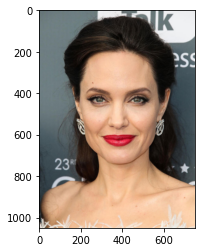


Target 0: img06.jpg    (verified: True  | name: Angelina Jolie)

Match 1:
Unique ID      : f2f32b8e-a4f8-4b76-889f-1d15420b4d87
Name           : Angelina Jolie
Image name     : img05.jpg
Image full path: /home/rpessoa/projects/loki/api/data/raw/img05.jpg
Face region    : [91, 105, 185, 251]
Embeddings:
  > ArcFace: [-0.026780826970934868, 0.08662890642881393, 0.08762025088071823, ... , 0.23432829976081848](len=512)

Match 2:
Unique ID      : 73dec355-2d1e-45e9-9d10-7c4370e44dc0
Name           : Angelina Jolie
Image name     : img07.jpg
Image full path: /home/rpessoa/projects/loki/api/data/raw/img07.jpg
Face region    : [405, 407, 579, 817]
Embeddings:
  > ArcFace: [-0.04091472551226616, 0.19594614207744598, 0.1693786084651947, ... , 0.23062342405319214](len=512)



In [10]:
fr_results   = []

# Let's do the whole pipeline for each image
for i, img_path in zip(range(len(targets_paths)), targets_paths):
    if i < 0:
        continue
    elif i == 1:
        break

    # Check if a representation exists for the current image in the database
    # rep, idx = find_image_in_db(img_path, rep_db, shortcut=None) # for now, no representation exists
    plt.imshow(mpimg.imread(img_path))
    plt.show()

    # Calculate the face image embedding
    region, embeddings = calc_embedding(img_path, models, align=align,
                                            detector_name=chosen_backend, 
                                            verifier_names=chosen_model,
                                            normalization=normalization)

    # Calculates the embedding of the current image and gets all embeddings
    # (relevant to this model) from the database
    cur_emb     = embeddings[chosen_model]
    dtb_embs    = get_embeddings_as_array(rep_db, chosen_model)

    # Calculates the similarity between the current embedding and all embeddings
    # from the database
    similarity_obj = calc_similarity(cur_emb, dtb_embs,
                                     metric=similarity_metric,
                                     model_name=chosen_model, threshold=-1)

    # Gets all matches
    matches = [rep_db[i] for i in similarity_obj['idxs']]
    
    # Prints current iteration, image information and verification result
    print('')
    print('Target {}: {}'.format(i, img_path.split('/')[-1]).ljust(22), end='')

    if len(matches) > 0:
        print(' (verified: True  | name: {})'.format(matches[0].name_tag))
    else:
        print(' (verified: False | name: ---)')

    print('')

    for j, match in enumerate(matches):
        print(f'Match {j+1}:')
        match.show_info()
        print('')

In [9]:
top_x = 5 # this is a function parameter

print('Calculating embeddings ... ', end='')

# Calculate the face image embedding
region, embeddings = calc_embedding(img_path, models, align=align,
                                    detector_name=chosen_backend, 
                                    verifier_names=chosen_model,
                                    normalization=normalization)

# Calculates the embedding of the current image and gets all embeddings
# (relevant to this model) from the database
target = embeddings[chosen_model]
target = target[None, :]
test   = get_embeddings_as_array(rep_db, 'ArcFace')
print('done!')

print('Creating faiss index object ... ', end='')
index = load_faiss_indexes('', test, metric='cosine', verbose=False)

print('Verifying using faiss ... ', end='')
similarity_obj = verify_with_faiss(target, index, rep_db, top_x=top_x,
                            model_name=chosen_model, metric=similarity_metric,
                            threshold=-1)
print('done!\n\nShowing matches:')

# Gets all matches
matches = [rep_db[i] for i in similarity_obj['idxs']]

for i, match in enumerate(matches):
    print(f'-----> Match {i+1}')
    match.show_info()
    print('')


Calculating embeddings ... done!
Creating faiss index object ... Verifying using faiss ... done!

Showing matches:
-----> Match 1
Unique ID      : 70ef9ad2-6450-43a5-bb23-faa3dfa779b1
Name           : Jennifer Aniston
Image name     : img03.jpg
Image full path: /home/rpessoa/projects/loki/api/data/raw/img03.jpg
Face region    : [470, 306, 645, 965]
Embeddings:
  > ArcFace: [0.0467110313475132, 0.09584441781044006, -0.17233353853225708, ... , 0.07490222156047821](len=512)

-----> Match 2
Unique ID      : f4f5cdeb-b6fc-434f-b33e-dd7f5f28c8a6
Name           : Angelina Jolie
Image name     : img05.jpg
Image full path: /home/rpessoa/projects/loki/api/data/raw/img05.jpg
Face region    : [91, 105, 185, 251]
Embeddings:
  > ArcFace: [-0.026780826970934868, 0.08662890642881393, 0.08762025088071823, ... , 0.23432829976081848](len=512)



### API development area:

In [4]:
chosen_model      = 'ArcFace'
chosen_backend    = 'retinaface'
align             = True
normalization     = 'base'
similarity_metric = 'cosine'
image_paths       = get_image_paths(RAW_DIR)
targets_paths     = get_image_paths(TARGETS_DIR)
image_tags        = ['Jennifer Aniston', 'Angelina Jolie', 'Angelina Jolie',
                     'Scarlett Johansson', 'Mark Zuckerberg', 'Elon Musk',
                     'Jeff Bezos', 'Sundar Pichai', 'Katy Perry']
img_dir           = RAW_DIR
db_path           = RDB_DIR # no database exists

new_db = create_reps_from_dir(img_dir, models, detector_name=chosen_backend,
                    align=align, verifier_names=chosen_model,
                    show_prog_bar=True, normalization='base', tags=image_tags,
                    uids=[], verbose=False)

Creating representations: 100%|██████████| 9/9 [00:46<00:00,  5.14s/it]


In [14]:
for rep in new_db:
    rep.show_info()
    print('')

Unique ID      : 0022b98a-a650-4742-b559-be58be278e46
Name           : 
Image name     : img03.jpg
Image full path: /home/rpessoa/projects/loki/api/data/raw/img03.jpg
Face region    : [470, 306, 645, 965]
Embeddings:
  > ArcFace: [0.0467110313475132, 0.09584441781044006, -0.17233353853225708, ... , 0.07490222156047821](len=512)

Unique ID      : 6d7680a2-5fff-42be-81e7-144ec479d12c
Name           : 
Image name     : img05.jpg
Image full path: /home/rpessoa/projects/loki/api/data/raw/img05.jpg
Face region    : [91, 105, 185, 251]
Embeddings:
  > ArcFace: [-0.026780826970934868, 0.08662890642881393, 0.08762025088071823, ... , 0.23432829976081848](len=512)

